## Basic library to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

## Specific library to import

In [2]:
import discretize
import empymod


## Project package to import

In [3]:
import Project
from Project import EMIP1D

In [4]:
EMIP1D?

Init signature:
EMIP1D(
    IP_model,
    model_base,
    res_air,
    res_sea,
    res_seafloor,
    nlayers,
    tindex,
    resmin=1e-10,
    resmax=10000000000.0,
    mmin=0,
    mmax=1.0,
    taumin=1e-10,
    taumax=10000000000.0,
    cmin=0,
    cmax=1.0,
)
Docstring:     
Class for one dimensional inversion for about Induced Polarization from
Time-Domain Electromagnetic about Sea Massive Sulfide Exploration.
Forward modelling: empymod
https://empymod.emsig.xyz/en/stable/index.html

Forward modelling: SimPEG

Inversion
    Jacobian is approximated by finite difference
    Objective function: f = 0.5*( phid + beta* phim)
    Data part: phid = (Wd(F(m)-dobs))**2
    Model part: phim = (Ws(mref-minit))**2

Parameters

IP_model: String
    "cole":
        res0: resistivity in low frequency
        res8: resistivity in hig frequency
        tau : time constant
        c   : relaxation parameter

    "pelton":
        res : resistivity
        m   : chargeability
        tau : time co

In [4]:
res_air = 2e14
res_sea = 1/3
res_seafloor = 1
nlayers = 1

layer_thicknesses = 50.
#seabed_depth = 1004
seabed_depth = 1000.1
depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers+1)])
#depth = np.array([0,seabed_depth])

In [5]:
# Configuration is inspired by JOGMEC WISTEM survey
# K.Nakayama(2014)
t = np.logspace(-4,-2, 61)
tstrt = 1e-4
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]

In [6]:

model_base = {
    'src':  [1.75,1.75,0,1.75,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [7]:
EMIP =  EMIP1D("pelton",model_base,
    res_air,res_sea,res_seafloor,nlayers,tindex)

In [11]:
EMIP.GaussNewton_Reg_LS?

Signature:
EMIP.GaussNewton_Reg_LS(
    dobs,
    model_init,
    niter,
    beta,
    alpha0=1,
    afac=0.5,
    atol=1e-06,
    gtol=0.001,
    mu=0.0001,
)
Docstring:
""
Gauss-Newton method
Line search method Amijo using directional derivative

parameter
    dobs: data
    model_init: initial model
    mref : applly initial model as reference model
    niter: max iteration number
    beta: beta for model part
    alpha0: initial alpha for line search
    afac: backtracking factor
    atol: min value for alpha
    gtol: minimum value for dradient, stopping criteria for inversion
    mu: parameter for directional derivative
File:      c:\users\81805\onedrive\33_ubc\06_eosc556\pycharm\project.py
Type:      method

In [8]:
# res_0 = 1/10 * np.ones(nlayers)
# m_0 = np.log(res_0)

res = 1/10 * np.ones(nlayers)
m_r = np.log(res)

# res_8 = 1/20 * np.ones(nlayers)
# m_8 = np.log(res_8)
m = 0.6
m_m = m 
#tau = [0,0, 1e-4]
m_t = np.log(1e-4)*np.ones(nlayers)
#c = [0,0, 0.5]
m_c = 0.5*np.ones(nlayers)

model_obs = np.hstack([m_r, m_m,m_t,m_c])
data_clean = EMIP.predicted_data(model_obs)

## Check simulated data with analytical result

In [9]:
relative_error=0.05
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

In [10]:
# res_0 = np.ones(nlayers)
# m_0 = np.log(res_0)

res = np.ones(nlayers)
m_r = np.log(res)

res_8 = np.ones(nlayers)
m_m =0.0
#m_8 = np.log(res_8)
#tau = [0,0, 1e-4]
m_t = np.log(1e-4)*np.ones(nlayers)
#c = [0,0, 0.5]
m_c = 0.5*np.ones(nlayers)
#m = (res_0 - res_8) / res_0
#print(f'chargeability for initial model{m}')

#model_init = np.hstack([m_0, m_8, m_t, m_c])
model_init = np.hstack([m_r, m_m, m_t, m_c])
data_init = EMIP.predicted_data(model_init)


In [11]:
niter = 20
beta = 1
#model_SD, error, model_itr = EMIP.steepest_descent_linesearch(data_obs, model_init, niter)
model_GN, error, model_itr = EMIP.GaussNewton_Reg_LS(
    dobs=data_obs, model_init=model_init, niter=niter,beta=beta,
    atol=1e-14, mu= 1e-4
)

Gauss-Newton 
 Initial phid = 3.93e+04 ,phim = 0.00e+00, error= 3.93e+04 
  1, alpha:3.91e-03, gradient:1.05e+04, phid:3.93e+04, phim:3.00e-03, f:3.93e+04 
  2, alpha:7.81e-03, gradient:1.51e+04, phid:3.90e+04, phim:2.52e-02, f:3.90e+04 
  3, alpha:1.25e-01, gradient:2.36e+04, phid:6.59e+03, phim:2.38e+00, f:6.59e+03 
  4, alpha:5.00e-01, gradient:3.05e+05, phid:8.22e+02, phim:2.98e+00, f:8.25e+02 
  5, alpha:1.00e+00, gradient:2.10e+04, phid:2.95e+02, phim:3.00e+00, f:2.98e+02 
  6, alpha:1.00e+00, gradient:3.57e+04, phid:1.93e+02, phim:3.01e+00, f:1.96e+02 
  7, alpha:1.00e+00, gradient:5.51e+03, phid:1.92e+02, phim:3.02e+00, f:1.95e+02 
  8, alpha:1.00e+00, gradient:1.25e+02, phid:1.92e+02, phim:3.02e+00, f:1.95e+02 
  9, alpha:1.00e+00, gradient:7.51e-01, phid:1.92e+02, phim:3.02e+00, f:1.95e+02 
 10, alpha:1.00e+00, gradient:8.08e-03, phid:1.92e+02, phim:3.02e+00, f:1.95e+02 
Inversion complete since norm of gradient is small as :3.369e-04 


In [12]:
data_pred = (EMIP.predicted_data(model_GN))

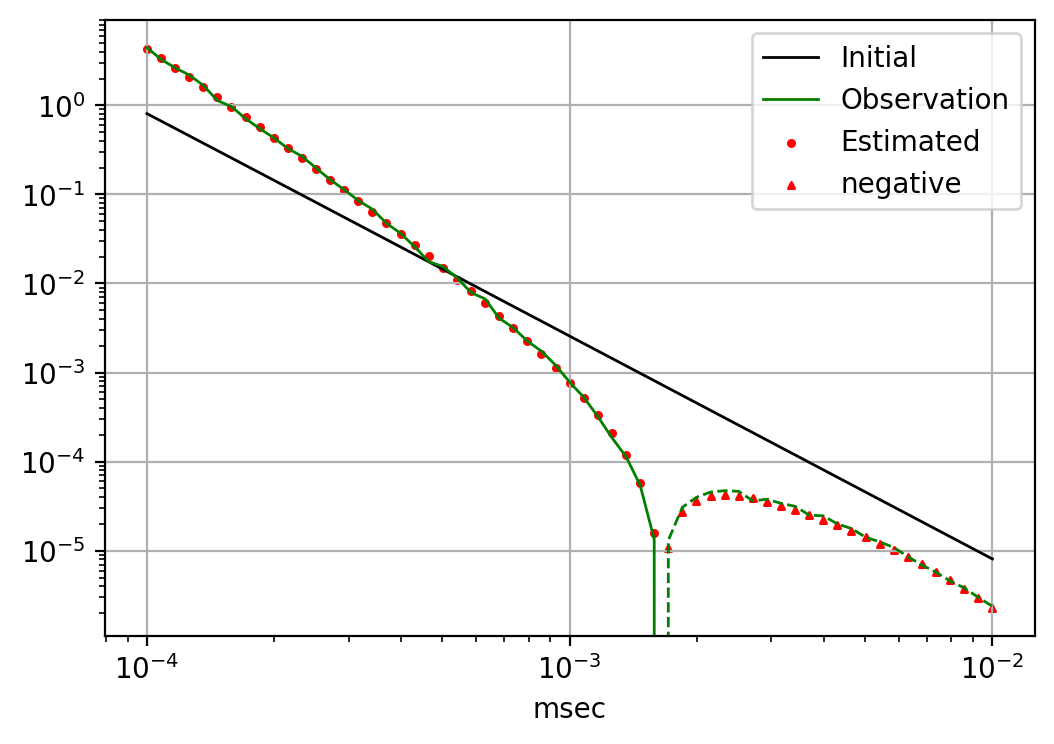

In [13]:
plt.figure(figsize=(6, 4),dpi=200)

plt.plot(tplot, data_init, "-", color="k", label="Initial", linewidth=1)
plt.plot(tplot, -data_init, "--", color="k", linewidth=1)

plt.plot(tplot, data_obs, "-", color="g", label="Observation", linewidth=1)
plt.plot(tplot, -data_obs, "--", color="g", linewidth=1)

plt.scatter(tplot, data_pred, color="r", label="Estimated", marker='o', s=5)
plt.scatter(tplot, -data_pred,  color="r", label="negative",marker='^', s=5)
plt.xlabel("msec")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


In [122]:
ngrid = 20
mirgin = 0.05
itr_st = 0

#m0_grid, m8_grid, cc_grid = EMIP.get_r08_grid(
mr_grid, mm_grid, rm_grid = EMIP.get_rm_grid(
    dobs=data_obs, 
    m_r=model_itr[itr_st:,0],
    m_m=model_itr[itr_st:,1],
    m_t=model_obs[2],
    m_c=model_obs[3],
    beta=beta, 
    mref=model_init,
    ngrid=ngrid,
    mirgin=mirgin    )


In [123]:
res_grid = np.exp(mr_grid)
chg_grid = mm_grid
# res0_grid = np.exp(m0_grid)
# res8_grid = np.exp(m8_grid)

In [124]:
res_tr = np.exp(model_itr[itr_st:,0])
chg_tr = model_itr[itr_st:,1]

Text(0, 0.5, 'Chargeabillity')

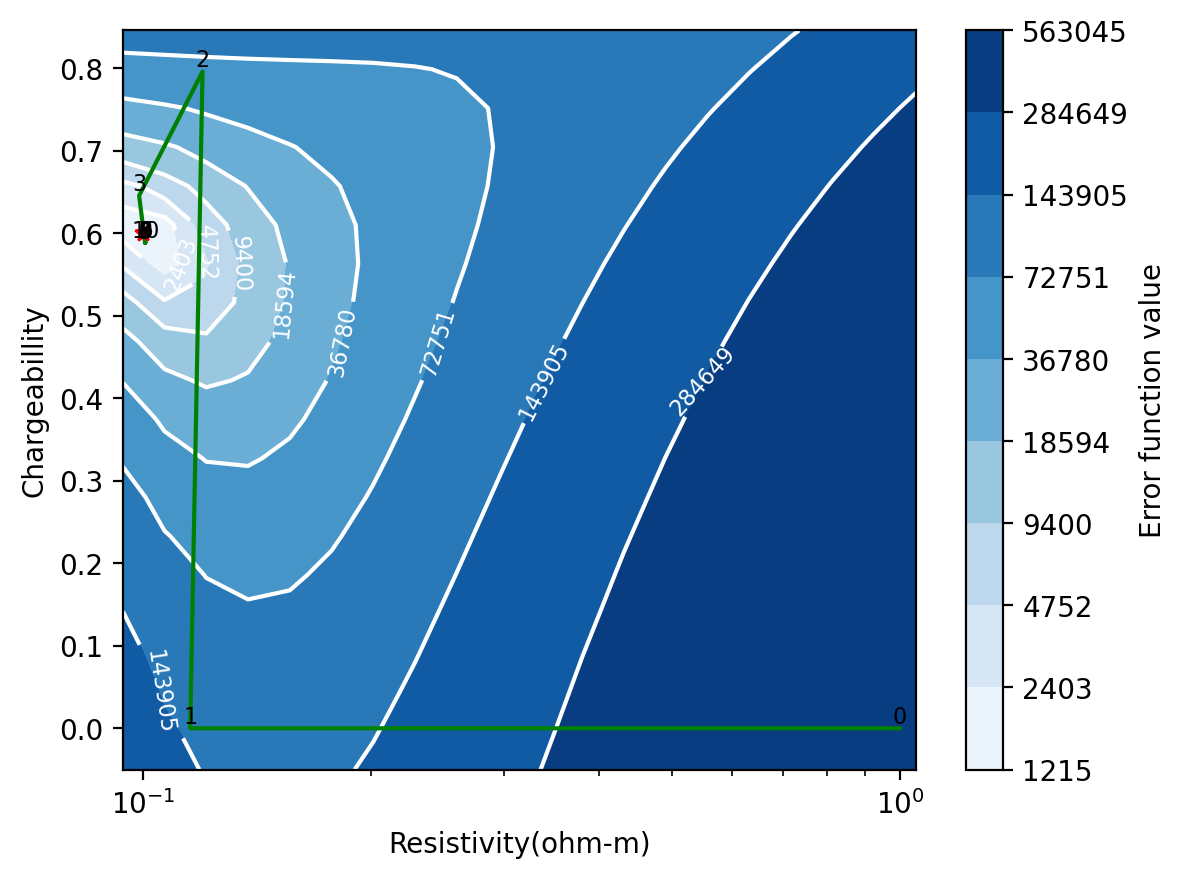

In [125]:
fig, ax = plt.subplots(1, 1,dpi=200)
# levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)
levels = np.logspace( np.log10( np.min( rm_grid) ), np.log10( np.max(rm_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues
norm = mcolors.LogNorm(vmin=np.min(rm_grid), vmax=np.max(rm_grid))

CF = ax.contourf(res_grid, chg_grid, rm_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax.contour(res_grid, chg_grid, rm_grid, levels=levels, colors="w")
CL = ax.clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax)

ax.plot(res_tr,chg_tr,"g")
for i, (x, y) in enumerate(zip(res_tr, chg_tr)):
    plt.text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
# ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
ax.plot(np.exp(model_obs[0]),model_obs[1],"r*")
CB.set_label("Error function value")
ax.set_yscale('linear')  
ax.set_xscale('log')  
ax.set_xlabel("Resistivity(ohm-m)")
ax.set_ylabel("Chargeabillity")

In [130]:
ngrid = 20
mirgin = 0.02
itr_st = 5

#m0_grid, m8_grid, cc_grid = EMIP.get_r08_grid(
mr_grid, mm_grid, rm_grid = EMIP.get_rm_grid(
    dobs=data_obs, 
    m_r=model_itr[itr_st:,0],
    m_m=model_itr[itr_st:,1],
    m_t=model_obs[2],
    m_c=model_obs[3],
    beta=beta, 
    mref=model_init,
    ngrid=ngrid,
    mirgin=mirgin    )


In [131]:
res_grid = np.exp(mr_grid)
chg_grid = mm_grid
# res0_grid = np.exp(m0_grid)
# res8_grid = np.exp(m8_grid)

In [132]:
res_tr = np.exp(model_itr[itr_st:,0])
chg_tr = model_itr[itr_st:,1]

Text(0, 0.5, 'Chargeabillity')

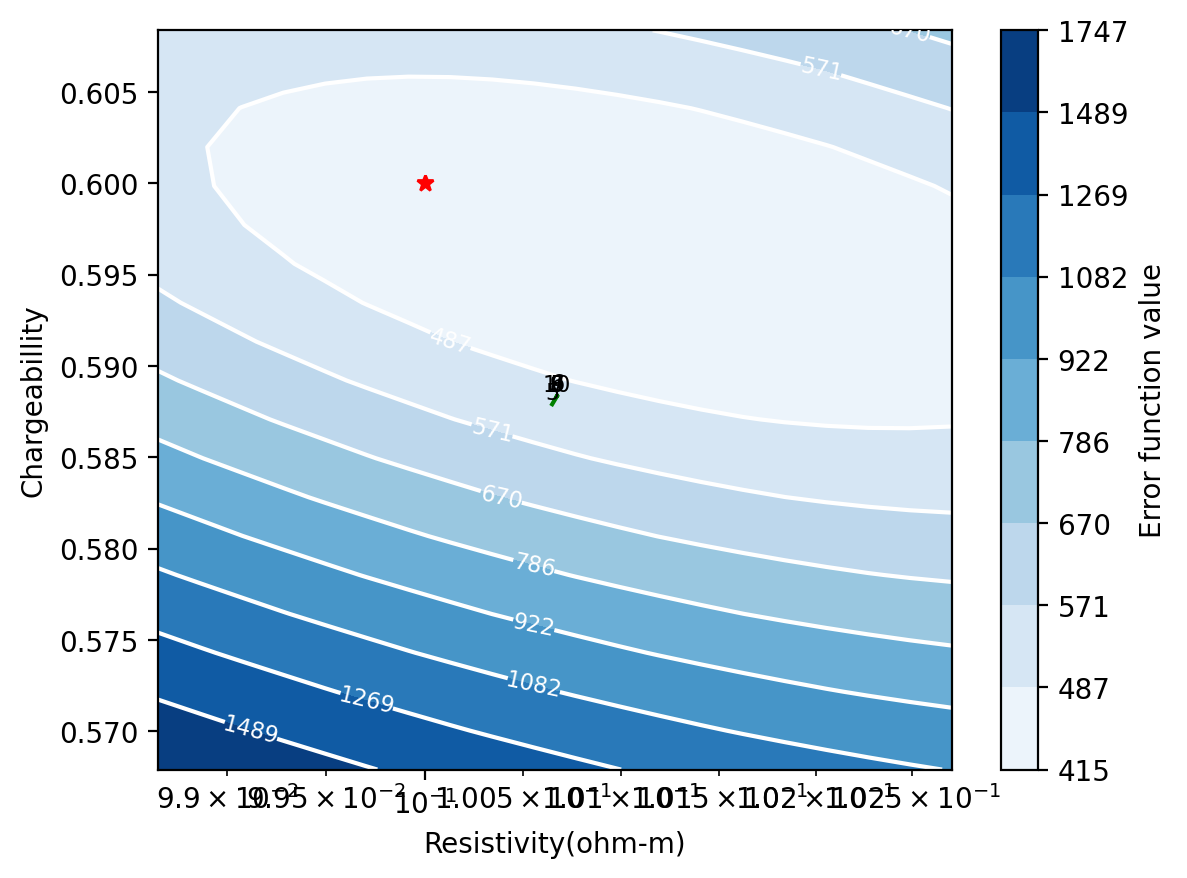

In [133]:
fig, ax = plt.subplots(1, 1,dpi=200)
# levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)
levels = np.logspace( np.log10( np.min( rm_grid) ), np.log10( np.max(rm_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues
norm = mcolors.LogNorm(vmin=np.min(rm_grid), vmax=np.max(rm_grid))

CF = ax.contourf(res_grid, chg_grid, rm_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax.contour(res_grid, chg_grid, rm_grid, levels=levels, colors="w")
CL = ax.clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax)

ax.plot(res_tr,chg_tr,"g")
for i, (x, y) in enumerate(zip(res_tr, chg_tr)):
    plt.text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
# ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
ax.plot(np.exp(model_obs[0]),model_obs[1],"r*")
CB.set_label("Error function value")
ax.set_yscale('linear')  
ax.set_xscale('log')  
ax.set_xlabel("Resistivity(ohm-m)")
ax.set_ylabel("Chargeabillity")

In [134]:
niter = 20
beta = 1
#model_SD, error, model_itr = EMIP.steepest_descent_linesearch(data_obs, model_init, niter)
model_SD, error, model_itr = EMIP.steepest_descent_Reg_LS(
    dobs=data_obs, model_init=model_init, niter=niter,beta=beta,
    mu= 1e-4,gtol=1e-3
)

Steepest Descent 
 Initial phid = 5.54e+05 ,phim = 0.00e+00, error= 5.54e+05 
  1, alpha:2.50e-01, gradient:1.29e+05, phid:1.29e+05, phim:5.97e+02, f:1.29e+05 
  2, alpha:2.50e-01, gradient:3.57e+01, phid:1.28e+05, phim:3.29e+02, f:1.29e+05 
  3, alpha:1.56e-02, gradient:2.10e+02, phid:1.27e+05, phim:2.52e+02, f:1.27e+05 
  4, alpha:3.91e-03, gradient:5.95e+02, phid:1.27e+05, phim:2.06e+02, f:1.27e+05 
  5, alpha:9.77e-04, gradient:1.78e+03, phid:1.27e+05, phim:2.37e+02, f:1.27e+05 
  6, alpha:1.95e-03, gradient:6.10e+02, phid:1.26e+05, phim:2.17e+02, f:1.27e+05 
  7, alpha:9.77e-04, gradient:7.35e+02, phid:1.26e+05, phim:2.22e+02, f:1.27e+05 
  8, alpha:9.77e-04, gradient:5.76e+02, phid:1.26e+05, phim:2.21e+02, f:1.27e+05 
  9, alpha:2.44e-04, gradient:6.00e+02, phid:1.26e+05, phim:2.21e+02, f:1.27e+05 
 10, alpha:9.54e-07, gradient:5.99e+02, phid:1.26e+05, phim:2.21e+02, f:1.27e+05 
 11, alpha:9.54e-07, gradient:5.99e+02, phid:1.26e+05, phim:2.21e+02, f:1.27e+05 
 12, alpha:9.54e-07,

In [16]:
data_pred = (EMIP.predicted_data(model_SD))

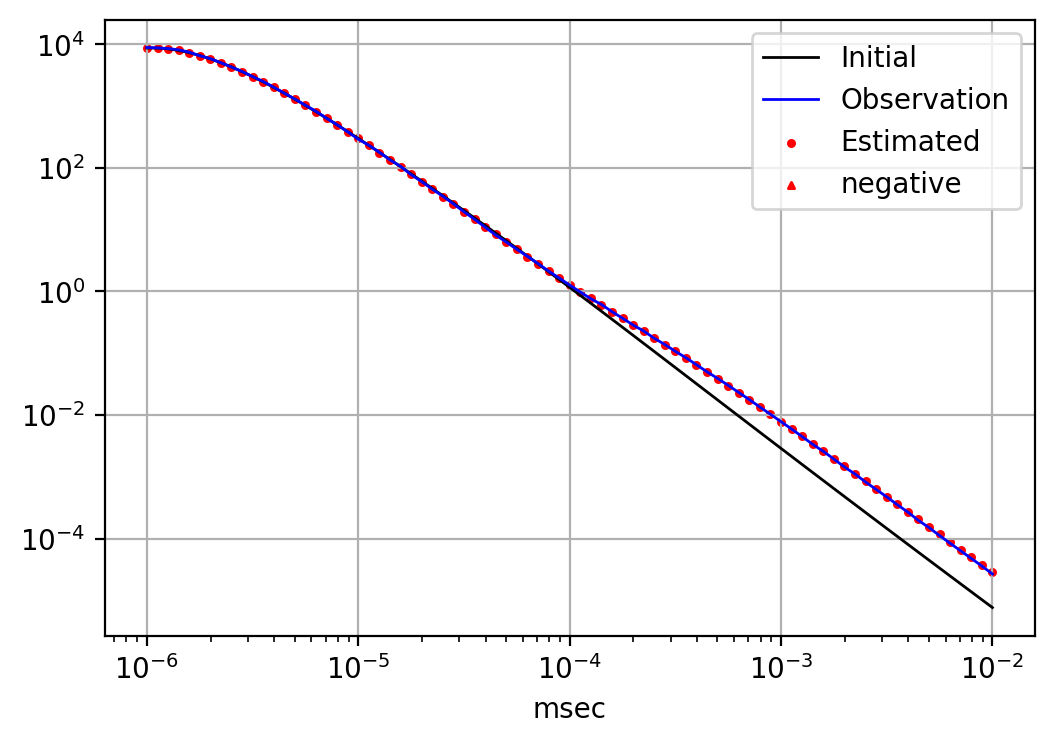

In [17]:
plt.figure(figsize=(6, 4),dpi=200)

plt.plot(tplot, data_init, "-", color="k", label="Initial", linewidth=1)
plt.plot(tplot, -data_init, "--", color="k", linewidth=1)

plt.plot(tplot, data_obs, "-", color="b", label="Observation", linewidth=1)
plt.plot(tplot, -data_obs, "--", color="b", linewidth=1)

plt.scatter(tplot, data_pred, color="r", label="Estimated", marker='o', s=5)
plt.scatter(tplot, -data_pred,  color="r", label="negative",marker='^', s=5)
plt.xlabel("msec")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()


In [ ]:
model_itr

In [ ]:
ngrid = 20
mirgin = 0.1
itr_st = 0
m0_grid, m8_grid, cc_grid = EMIP.get_cc_grid(
    dobs=data_obs, 
    m_0=model_itr[itr_st:,0],
    m_8=model_itr[itr_st:,1],
    m_t=model_obs[2],
    m_c=model_obs[3],
    beta=beta, 
    mref=model_init,
    ngrid=ngrid,
    mirgin=0.1
    )


In [ ]:
res0_grid = np.exp(m0_grid)
res8_grid = np.exp(m8_grid)

In [ ]:
res0_tr = np.exp(model_itr[itr_st:,0])
res8_tr = np.exp(model_itr[itr_st:,1])

In [ ]:
fig, ax = plt.subplots(1, 1,dpi=200)
levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues_r
norm = mcolors.LogNorm(vmin=np.min(cc_grid), vmax=np.max(cc_grid))

CF = ax.contourf(res0_grid, res8_grid, cc_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax.contour(res0_grid, res8_grid, cc_grid, levels=levels, colors="w")
CL = ax.clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax)

ax.plot(res0_tr,res8_tr,"g")
for i, (x, y) in enumerate(zip(res0_tr, res8_tr)):
    plt.text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
ax.plot(np.exp(model_obs[0]),np.exp(model_obs[1]),"r*")
CB.set_label("Error function value")
ax.set_xscale('log')  # Set x-axis to logarithmic scale
ax.set_yscale('log')  # Set y-axis to logarithmic scale

In [ ]:
fig, ax = plt.subplots(1, 1,dpi=200)
levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues_r
norm = mcolors.LogNorm(vmin=np.min(cc_grid), vmax=np.max(cc_grid))

CF = ax.contourf(m0_grid, m8_grid, cc_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax.contour(m0_grid, m8_grid, cc_grid, levels=levels, colors ="w")
CL = ax.clabel(CS, inline=True, fontsize=8)
CB = fig.colorbar(CF, ax=ax)
CB.set_label("Error function value")

ax.plot(model_itr[itr_st:,0],model_itr[itr_st:,1],"g")
ax.plot(model_obs[0],model_obs[1],"r*")
#CS = ax.contour(res0_grid,res8_grid,cc_grid.T, levels=10)
for i, (x, y) in enumerate(zip(model_itr[itr_st:,0], model_itr[itr_st:,1])):
    plt.text(x, y, str(itr_st+i), fontsize=8, color='black', ha='center', va='bottom')
